## In what ways has social media contributed to the growth and visibility of the Fridays for Future climate movement?


In [ ]:
import pandas as pd
from googleapiclient.discovery import build
from collections import OrderedDict
from collections import Counter

api_key = ""
youtube = build("youtube", "v3", developerKey= api_key)


def flatten(xss):
    '''Function that flattens one list
       i: list in list
       o: list'''
    return [x for xs in xss for x in xs]


def search_video(before=None, after=None, filename="input.csv"):
    '''Searches youtube videos with given parameters
       and saves them as a csv'''
    all_videos = []
    next_page_token = None
    max_pages = 2
    current_page = 0

    # Iterates through max_pages pages and returns the videos
    while current_page < max_pages:
        parameters = {
            "q": "Friday for Future",
            "maxResults": 50,
            "part": "snippet",
            "order": "relevance",
            "type": "video",
            "relevanceLanguage":"de",
            "videoCategoryId": "25" # Politics and news
        }
        if before is not None:
            parameters["publishedBefore"] = before
        if after is not None:
            parameters["publishedAfter"] = after
        if next_page_token:
            parameters["pageToken"] = next_page_token

        request = youtube.search().list(**parameters)
        response = request.execute()
        all_videos.extend(response["items"])

        next_page_token = response.get("nextPageToken")
        current_page += 1

    # List of video ids
    ids = []
    for item in all_videos:
        ids.append(item["id"]["videoId"])

    # List of titles
    titles = []
    for item in all_videos:
        titles.append(item["snippet"]["title"])


    # List of comments for each video
    all_comments = []

    for videoid in ids:
        video_comments = []
        try:
            request = youtube.commentThreads().list(
                part="snippet",
                videoId=videoid,
                maxResults=10,
                textFormat="plainText",
                order="relevance"
            )
            response = request.execute()
            for c in response.get("items", []):
                video_comments.append(c["snippet"]["topLevelComment"]["snippet"]["textDisplay"])

        # Comments may be disabled
        except Exception as e:
            continue

        all_comments.append(video_comments)
    
    # List of description for each video
    descriptions =[]
    for video_id in ids:
        try:
            request = youtube.videos().list(
                part="snippet",
                id=video_id
        )
            response = request.execute()
            for item in response.get("items", []):
                description = item["snippet"].get("description", "")
                descriptions.append(description)

        except Exception as e:
             continue
        
    # Comments are list in list
    comments = flatten(all_comments)

    final_data = titles + comments 


    df = pd.DataFrame(final_data, columns=["text"])
    df.to_csv(filename, index=False, encoding="utf-8")
    return ids, final_data


In [ ]:
def video_count(video_list, counts="numbers.csv", sorted_count="sorted.csv"):
    '''Counts the amount of videos per each day 
       and sorts videos by view count'''
    
    df = pd.DataFrame(video_list)

    df["upload time"] = pd.to_datetime(df["upload time"])
    df["year_month_day"] = df["upload time"].dt.to_period("D")

    # Count the number of videos per day and sort by date
    video_counts = df["year_month_day"].value_counts().sort_index()

    df_counts = video_counts.reset_index()
    df_counts.columns = ["year_month_day", "video_count"]
    df_counts.to_csv(counts, encoding="utf-8", index=False)

    # Sorts the videos by view count
    sorted_videos = sorted(video_list, key=lambda x: x["views"], reverse=True)
    df_sorted = pd.DataFrame(sorted_videos)
    df_sorted.to_csv(sorted_count, encoding="utf-8", index=False)
    
    return df_counts, df_sorted


    
def get_data(data_ids):
    '''Gets title, views, likes, comments and upload time
       for each video'''
    
    video_data = []

    for item in data_ids:
        request = youtube.videos().list(
            part="snippet, statistics",
            id=item
        )
        response = request.execute()
    
        for video in response.get("items", []):

            # Extracts the title from each video snippet
            title = video["snippet"].get("title", "")

            # Extracts the statistics for each video
            stats = video.get("statistics", {})
            views = int(stats.get("viewCount", 0))
            likes = int(stats.get("likeCount", 0))
            comments = int(stats.get("commentCount", 0))

            upload_time = video["snippet"].get("publishedAt", "")

            # Dict with the video info
            video_data.append({
                "title": title,
                "views": views,
                "likes": likes,
                "comments": comments,
                "upload time": upload_time
            
        })
    return video_data





In [ ]:
!python -m spacy download de_core_news_sm

In [ ]:
import keybert
import spacy
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Extracts default german stopwords from spaCy
nlp = spacy.load("de_core_news_sm")
german_stopwords = nlp.Defaults.stop_words

def keywords(data):
    model = keybert.KeyBERT() 
    keywords_list = []

    for item in data:
        # Ensures that given data consists of strings
        text = str(item)

        # Extracts 1-word keyphrases from text 
        kw_single = model.extract_keywords(text, keyphrase_ngram_range=(1,1))
        keywords_list.extend(kw_single)

    # List of specific words and german stopwords that should be filtered out
    ignore_words = ["fridays", "fridays future", "video", "fuß", "sehen", "20", "quot", "mal", "herr", "innen", "echt", "19" ]
    all_stopwords = german_stopwords.union(ignore_words)

    # Flattens the keywords and filters out ignored words
    flattened_keywords = [kw for kw, score in keywords_list if kw.lower() not in all_stopwords]


    # Count how many times each keyword appears and only keeps them if >3 times
    keywords_df = pd.DataFrame(Counter(flattened_keywords).items(), columns=["words", "numbers"])
    frequent_words = keywords_df.loc[keywords_df['numbers'] > 3].sort_values(by='numbers', ascending=False)
    frequent_words.to_csv("keywords.csv", index=False, encoding="utf-8")

    # Creates a WordCloud out of the keywords 
    wordcloud = WordCloud(background_color="white",
                      width=2500,
                      colormap="winter",    
                      height=1000,
                      scale=2.0,
                      min_font_size=6).fit_words(dict(Counter(flattened_keywords))).to_file('arxiv_word_cloud.png')
    plt.figure(figsize=(15, 6))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()




In [ ]:
# Getting the raw data for 3 specific times
x,y = search_video("2019-06-01T00:00:00Z", "2019-01-01T00:00:00Z", filename="dataSetTilJune.csv")
x2,y2 = search_video("2020-01-01T00:00:00Z", "2019-06-01T00:00:00Z", filename="dataSetTilDec20.csv")
x3,y3 = search_video("2021-01-01T00:00:00Z", "2020-01-01T00:00:00Z", filename="dataSetTilDec21.csv")

# Processes the Data
data1 = get_data(x)
video_count(data1, "data1_num.csv", "data1_sort.csv")
data2 = get_data(x2)
video_count(data2, "data2_num.csv", "data2_sort.csv")
data3 = get_data(x3)
video_count(data3, "data3_num.csv", "data3_sort.csv")

df1 = pd.read_csv("data1_num.csv")
df2 = pd.read_csv("data2_num.csv")
df3 = pd.read_csv("data3_num.csv")

df_all = pd.concat([df1, df2, df3], ignore_index=True)
df_all.to_csv("combined_numbers.csv", index=False)

full_data = y + y2 + y3



              words  numbers
2            future      129
28            klima       29
14             demo       29
48            greta       27
82      klimaschutz       22
...             ...      ...
624      engagement        4
971          arbeit        4
718   klimaproteste        4
1428        siemens        4
1518       schinkel        4

[93 rows x 2 columns]


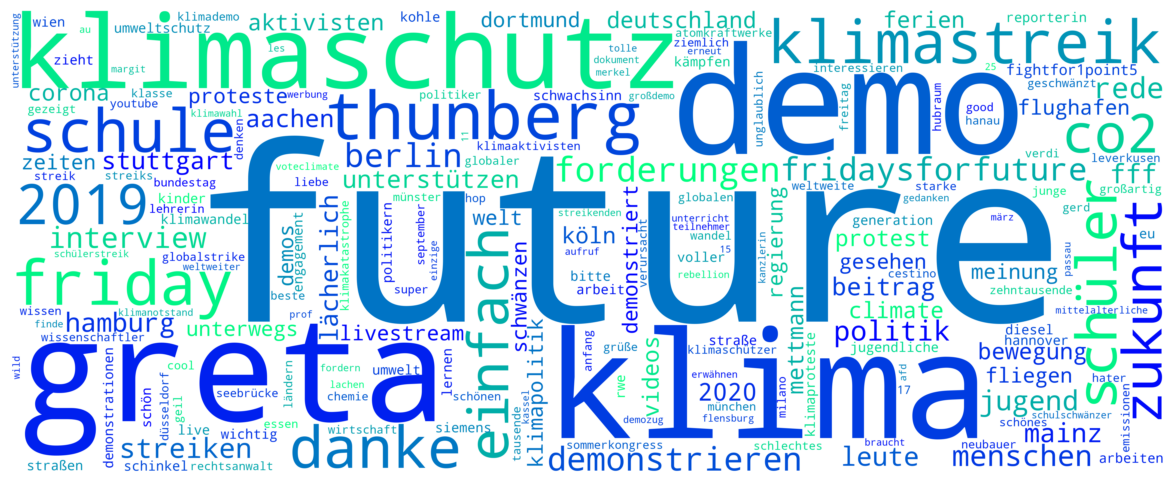

In [ ]:
# Gets the WordCloud for all titles + descriptions + comments
keywords(full_data)

In [ ]:
import pandas as pd
from io import StringIO
import requests

url = "https://en.wikipedia.org/wiki/List_of_school_climate_strikes"
headers = {"User-Agent": "Data Science Analytics (Dianer)"}
response = requests.get(url, headers=headers)

# Reads all HTML tables from the response
tables = pd.read_html(StringIO(response.text))

df = tables[0]

# Filters for Strikes in Germany (or multiple countries, where germany is included)
if "Country" in df.columns:
    df_germany = df[df["Country"].str.contains("Germany|Countries", case=False, na=False)]


columns = ["Date"]
df_germany = df_germany[columns]
df_germany["Date"] = pd.to_datetime(df_germany["Date"])

# Filters for strikes only in the relevant timeframe
df_germany = df_germany[(df_germany["Date"] >= "2019-01-01") & (df_germany["Date"] < "2021-01-01")]
df_germany.to_csv("fff_germany_strikes.csv", index=False, encoding="utf-8")

          Date
24  2019-01-18
27  2019-01-25
31  2019-02-01
35  2019-02-08
43  2019-02-15
81  2019-03-15
108 2019-03-29
110 2019-04-05
115 2019-04-12
132 2019-05-11
139 2019-05-24
151 2019-06-21
152 2019-06-28
154 2019-07-05
155 2019-07-19
162 2019-09-20
163 2019-09-27
171 2019-12-06
179 2020-09-25


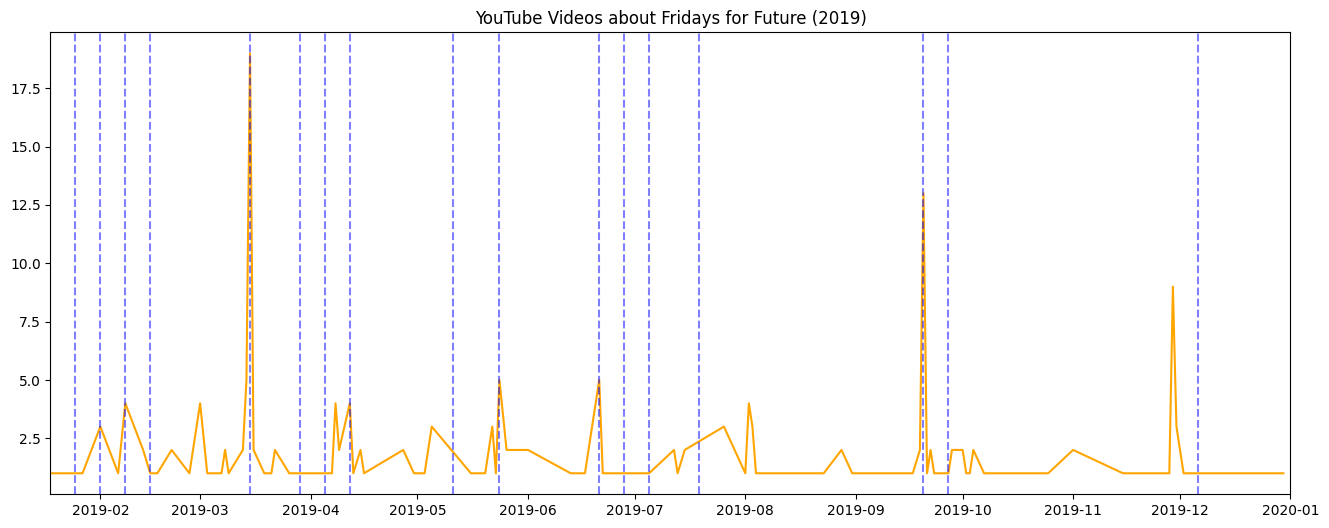

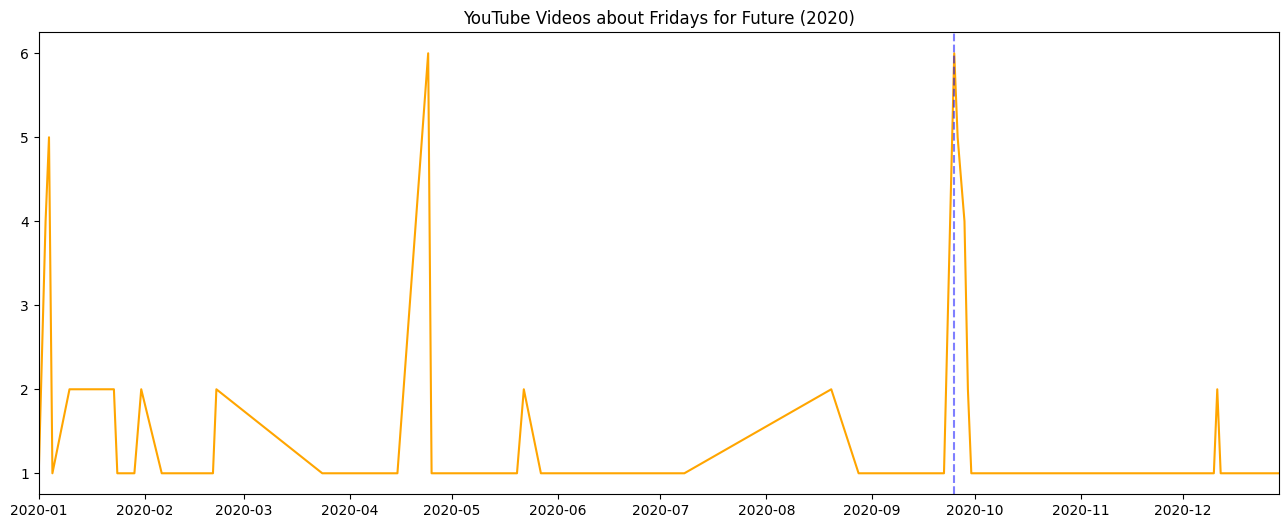

In [69]:
import pandas as pd
import matplotlib.pyplot as plt


df = pd.read_csv("combined_numbers.csv", parse_dates=["year_month_day"])
df_protests = pd.read_csv("fff_germany_strikes.csv", parse_dates=["Date"])

df_2019 = df[df["year_month_day"].dt.year == 2019]
protests_2019 = df_protests[df_protests["Date"].dt.year == 2019]

plt.figure(figsize=(16,6))
plt.plot(df_2019["year_month_day"], df_2019["video_count"], color="orange")
for protest_day in protests_2019["Date"]:
    plt.axvline(protest_day, color="blue", linestyle="--", alpha=0.5)
plt.title("YouTube Videos about Fridays for Future (2019)")
plt.xlim(df["year_month_day"].min(),pd.Timestamp("2020-01-01"))
plt.show()

df_2020 = df[df["year_month_day"].dt.year == 2020]
protests_2020 = df_protests[df_protests["Date"].dt.year == 2020]

plt.figure(figsize=(16,6))
plt.plot(df_2020["year_month_day"], df_2020["video_count"], color="orange")
for protest_day in protests_2020["Date"]:
    plt.axvline(protest_day, color="blue", linestyle="--", alpha=0.5)
plt.title("YouTube Videos about Fridays for Future (2020)")
plt.xlim(pd.Timestamp("2020-01-01"),df["year_month_day"].max())
plt.show()

In [70]:
import pandas as pd
from collections import Counter
keywords = pd.read_csv("keywords.csv")["words"].str.lower().tolist()

def check_keywords(video_df):
    '''Checks which keywords appear in the top 10
    most viewed/liked videos'''
    df = pd.read_csv(video_df)
    results = []
    df  = df.head(10)
    counts = Counter()
    
    for _, row in df.iterrows():
        title = str(row["title"]).lower()
        found = {kw for kw in keywords if kw in title}
        for kw in found:
            counts[kw] += 1
    
    return counts

counts1 = check_keywords("data1_sort.csv")
counts2 = check_keywords("data2_sort.csv")
counts3 = check_keywords("data3_sort.csv")

print("Data1:", counts1)
print("Data2:", counts2)
print("Data3:", counts3)

pd.DataFrame.from_dict(counts1, orient="index", columns=["count"]).to_csv("keyword_counts_data1.csv")
pd.DataFrame.from_dict(counts2, orient="index", columns=["count"]).to_csv("keyword_counts_data2.csv")
pd.DataFrame.from_dict(counts3, orient="index", columns=["count"]).to_csv("keyword_counts_data3.csv")
    
    

Data1: Counter({'friday': 10, 'future': 10, 'demo': 3, 'greta': 3, 'thunberg': 3, 'schüler': 2, 'klima': 2, 'protest': 1, 'proteste': 1, 'streiken': 1, 'schwänzen': 1, 'klimastreik': 1, 'eu': 1, 'aktivisten': 1, 'welt': 1, 'bewegung': 1, 'wien': 1})
Data2: Counter({'friday': 10, 'future': 9, 'greta': 3, 'eu': 2, 'klima': 2, 'thunberg': 2, 'protest': 2, 'proteste': 2, 'interview': 1, 'aachen': 1, 'zukunft': 1, 'klimaproteste': 1, 'welt': 1})
Data3: Counter({'friday': 6, 'future': 6, 'eu': 3, 'greta': 3, 'thunberg': 3, 'klima': 2, 'fightfor1point5': 2, 'interview': 1, 'climate': 1, 'corona': 1, 'kohle': 1, 'zeiten': 1})


In [71]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

all_keywords = list(set(counts1.keys()) | set(counts2.keys()) | set(counts3.keys()))

df_counts = pd.DataFrame({
    "Jan2019 - May2019": [counts1.get(k,0) for k in all_keywords],
    "July2019 - Dec2019": [counts2.get(k,0) for k in all_keywords],
    "Jan2020 - Dec2020": [counts3.get(k,0) for k in all_keywords]
}, index=all_keywords)

df_counts["total"] = df_counts.sum(axis=1)
df_filtered = df_counts[df_counts["total"] > 1].drop(columns="total")
df_filtered.to_csv("keyword_counts_combined.csv", encoding="utf-8")
print(df_counts.head())



                 Jan2019 - May2019  July2019 - Dec2019  Jan2020 - Dec2020  \
eu                               1                   2                  3   
fightfor1point5                  0                   0                  2   
klima                            2                   2                  2   
corona                           0                   0                  1   
greta                            3                   3                  3   

                 total  
eu                   6  
fightfor1point5      2  
klima                6  
corona               1  
greta                9  


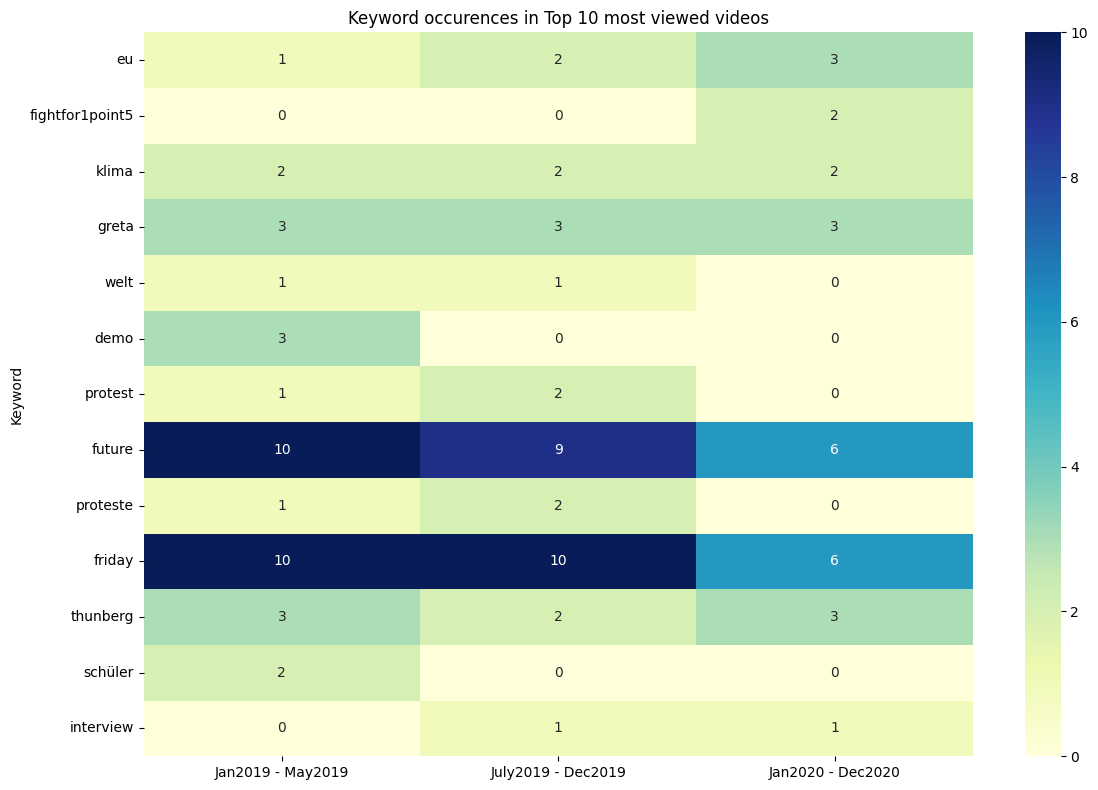

In [72]:
df_counts = pd.read_csv("keyword_counts_combined.csv", index_col=0)
plt.figure(figsize=(12,8))
sns.heatmap(df_counts, annot=True, fmt="d", cmap="YlGnBu")
plt.title("Keyword occurences in Top 10 most viewed videos")
plt.ylabel("Keyword")
plt.tight_layout()
plt.show()